In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

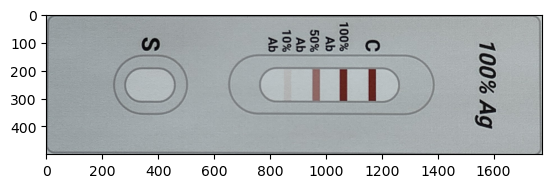

In [91]:
# image = cv2.imread('../assets/test_imgs/crop.png')
image = cv2.imread('../assets/test_imgs/crop4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

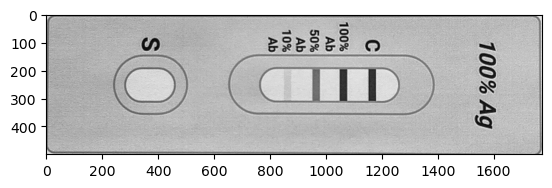

In [114]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
gray = clahe.apply(gray)
plt.imshow(gray, cmap='gray')

In [124]:
import numpy as np
import cv2
from PIL import Image


class VesseleFFT:
	# Recommond params:
	# Palmvein: d0=0.01, a=0.2, b=1.0, n=0.8
	# Palmprint: d0=0.05, a=0.5, b=1.0, n=0.8
	
	def __init__(self, d0=0.01, a=0.2, b=1.0, n=0.8, process_shape=(300, 300)):
		self.D0 = d0
		self.a = a
		self.b = b
		self.n = n
		self.process_shape = process_shape

	def enhance(self, image):
		imgfft = np.fft.fft2(image)
		imgfft = np.fft.fftshift(imgfft)

		height, width = image.shape
		x = (np.ones((1, height)).T.dot(np.array([np.arange(width)])) - np.floor(width/2))/width
		y = (np.array([np.arange(height)]).T.dot(np.ones((1, width))) - np.floor(height/2))/height
		radius = np.sqrt(x**2 + y**2)

		f = self.a + self.b / (1.0 + np.power((self.D0 / radius), (2*self.n)))
		imgfft = imgfft * f

		imgifft = np.fft.ifftshift(imgfft)
		imgifft = np.fft.ifft2(imgifft)

		outImage = imgifft.real
		outImage[outImage<0]=0
		outImage /= outImage.max()
		return np.array(outImage*255, dtype=np.uint8)
		
	def __call__(self, image):
		# image: PIL.Image
		if type(image) == str:
			image = cv2.imread(image, 0)
		# if type(image) == Image.Image:
		else:
			image = np.array(image)
			if len(image.shape) == 3:
				image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
		
		img_resized = cv2.resize(image, self.process_shape)
		out_image = cv2.cvtColor(self.enhance(img_resized), cv2.COLOR_GRAY2RGB)
		return Image.fromarray(out_image)


/tmp/ipykernel_3073560/1092095602.py:27: RuntimeWarning: divide by zero encountered in divide
  f = self.a + self.b / (1.0 + np.power((self.D0 / radius), (2*self.n)))


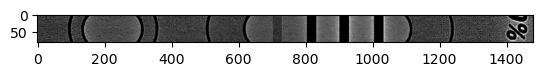

In [126]:
h, w = gray.shape
mid_h = h // 2
mid_w = w // 2
window_size_h = h // 12
window_size_w = w // 12
center_area = gray[mid_h-window_size_h:mid_h+window_size_h, window_size_w:-window_size_w]
# center_area = gray[window_size_h:-window_size_h, w//3: -w//7]
# center_area = gray[mid_h-window_size_h:mid_h+window_size_h, w//2: -w//7]

vh = VesseleFFT(d0=0.01, a=0.2, b=1.0, n=0.8)
center_area = vh.enhance(center_area)
plt.imshow(center_area, cmap='gray')

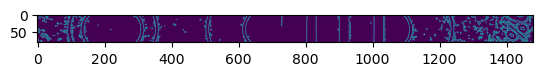

In [134]:
# Apply GaussianBlur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(center_area, (3, 3), 0)

# Use Canny edge detection
edges = cv2.Canny(blurred, 100, 200)
plt.imshow(edges)


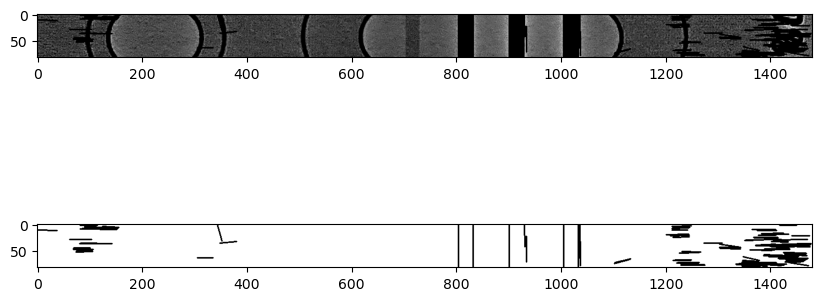

In [135]:
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=20, minLineLength=30, maxLineGap=10)

# Draw lines on the original image
output_image = center_area.copy()
blank = np.ones_like(output_image) * 255
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.line(blank, (x1, y1), (x2, y2), (0, 255, 0), 2)


# Show both images in two subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].imshow(output_image, cmap='gray')
ax[1].imshow(blank, cmap='gray')
plt.show()

In [29]:
lines

array([[[738,  71, 738,   0]],

       [[824,  71, 824,   0]],

       [[892,  71, 892,   0]],

       [[801,  71, 801,   0]],

       [[648,  71, 648,   0]],

       [[915,  71, 915,   0]],

       [[624,  71, 624,   0]],

       [[715,  71, 715,   0]]], dtype=int32)

In [30]:
lines.shape

(8, 1, 4)

In [31]:
blocks_p = lines.reshape(8, -1)[:, 0]
blocks_p.sort()
blocks_p = blocks_p.reshape(4, 2)
blocks_p

array([[624, 648],
       [715, 738],
       [801, 824],
       [892, 915]], dtype=int32)

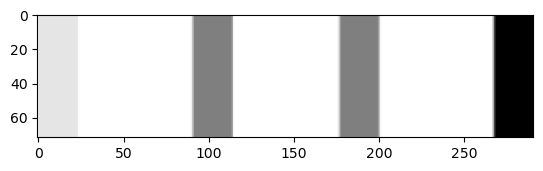

In [32]:
plt.imshow(center_area[:, blocks_p[0,0]:blocks_p[-1,-1]], cmap='gray')

In [33]:
avg_values = [255-center_area[:, i[0]:i[1]].mean() for i in blocks_p]
avg_values

[18.5, 92.21739130434781, 91.91304347826087, 184.8695652173913]